Now I want to compare and contrast the manual process and results that I got after working on the liver data, with the information originally included in said data by the researchers.

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from mygene import MyGeneInfo

In [3]:
# --- Step 1: Load Both AnnData Objects ---
# IMPORTANT: Replace these filenames with the correct paths to your files.
original_adata_path = "tabula-muris-senis-facs-processed-official-annotations-Liver.h5ad" # The original file
processed_adata_path = "Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad"      # Your processed file with scores/flags


print(f"Loading original data from: {original_adata_path}")
adata_original = sc.read_h5ad(original_adata_path)

print(f"Loading your processed data from: {processed_adata_path}")
adata_processed = sc.read_h5ad(processed_adata_path)

# --- Step 2: High-Level Structural Comparison ---
# Compare shapes, embeddings, and other stored data.
print("\n--- High-Level Structural Comparison ---")
print(f"Original Data Shape: {adata_original.n_obs} cells × {adata_original.n_vars} genes")
print(f"Processed Data Shape: {adata_processed.n_obs} cells × {adata_processed.n_vars} genes")


# Check if the cell and gene orders are the same (they should be if you didn't filter)
if adata_original.obs_names.equals(adata_processed.obs_names):
    print("\nCell names and order are identical between the two files. Good!")
else:
    print("\nWarning: Cell names or order differ. Direct comparison might be misleading.")

print("\n--- Comparing available cell annotations (.obs columns) ---")
original_obs_cols = set(adata_original.obs.columns)
processed_obs_cols = set(adata_processed.obs.columns)
new_cols = processed_obs_cols - original_obs_cols
shared_cols = processed_obs_cols.intersection(original_obs_cols)
print(f"Shared Columns ({len(shared_cols)}): {list(shared_cols)}")
print(f"New Columns in Processed Data ({len(new_cols)}): {list(new_cols)}")

print("\n--- Comparing available embeddings (.obsm keys) ---")
print(f"Original embeddings: {list(adata_original.obsm.keys())}")
print(f"Processed embeddings: {list(adata_processed.obsm.keys())}")


Loading original data from: tabula-muris-senis-facs-processed-official-annotations-Liver.h5ad


c:\Users\lukas\miniconda3\envs\sc_env\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(
c:\Users\lukas\miniconda3\envs\sc_env\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(


Loading your processed data from: Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad

--- High-Level Structural Comparison ---
Original Data Shape: 2859 cells × 22966 genes
Processed Data Shape: 2859 cells × 22966 genes

Cell names and order are identical between the two files. Good!

--- Comparing available cell annotations (.obs columns) ---
Shared Columns (15): ['method', 'cell', 'louvain', 'free_annotation', 'cell_ontology_class', 'FACS.selection', 'cell_ontology_id', 'age', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'mouse.id', 'leiden']
New Columns in Processed Data (25): ['is_high_CellAge', 'doublet_score', 'senescence_category_2', 'HernandezSegura_depleted_score', 'log1p_n_genes_by_counts', 'age_sex', 'is_high_Hernandez', 'pct_counts_in_top_200_genes', 'SenMayo_score', 'leiden_1.0', 'leiden_0.5', 'leiden_0.75', 'cell_type', 'CellAge_up_score', 'total_counts', 'pct_counts_in_top_50_genes', 'n_genes_by_counts', 'pct_counts_in_top_500_genes', 'log1p_to

Based on this information we can now know what and how to make comparisons between the original and the processed data.

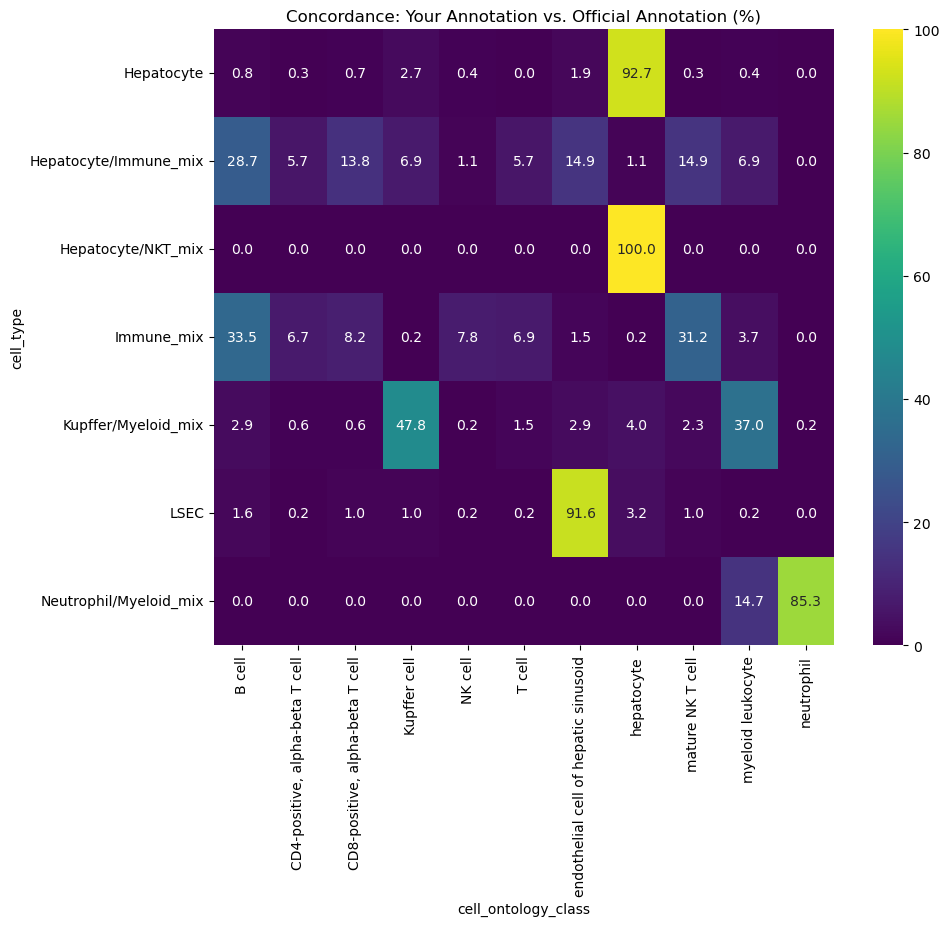

In [4]:
# Create the crosstab table
contingency_table = pd.crosstab(
    adata_processed.obs['cell_type'],              # Your annotations (rows)
    adata_original.obs['cell_ontology_class']      # Official annotations (columns)
)

# For a better visual, normalize it to see percentages
normalized_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Visualize as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_table, annot=True, fmt=".1f", cmap="viridis")
plt.title("Concordance: Your Annotation vs. Official Annotation (%)")
plt.show()

Here we can see the Heatmap that allows an intuitive comparison between how close or distant my annotation was from the original data. 

The first thing we notice is that while my data was categorized in only 7 different "cell type" clusters, with some clusters ending up with a mixture of cell types, the original data managed to segregate the cell types independently. Why? The researchers mention that they did a batch correction. Its possible that after correcting for the technical noise derived from the different samples the data becomes easier to classify and cell types become more segregated. For example cells of the same type (e.g., B cells) from two different mice will be pushed apart in the UMAP, while different cell types from the same mouse (e.g., a B cell and a T cell) might be pulled closer together. This is what creates those "muddled" clusters where biology is mixed with technical noise. The researchers explicitly state that they performed batch correction to integrate the data from the two different technologies (FACS and droplet) (Extended Data Fig. 1), which they identified as a major source of technical noise so it seems like this is the more likely case for the difference in results (testing for method-associated batch effects).

Its also possible that this original classification from the researchers is derived from both smartseq2 and droplet data combined, providing a much larger dataset that can see weaker signals better, whereas in mine the data and the clusters end up with mixed cell types. While droplet gives us breadth, obtaining thousands of cells per sample, great for identifying rare cell types and getting statistically robust clusters, smartseq 2 gives us depth, capturing many more genes and transcripts per cell but getting fewer overall cells. This is especially crucial for the immune department, where cell types are defined by a handful of key marker genes that might be sparsely detected in droplet data. The researchers also mention that they ran the clustering multiple times using different resolutions for robustness, but i also did the same so it seems that the batch correction is the factor that is making our results differ. Also instead of only clustering the facs or the droplet separately they utilized all 356.213 cells in the dataset.

Either way we can see that the clusters that i marked as Hepatocyte and Hepatocyte/NKT mix overlap very well with the cells classified as Hepatocytes by the original researchers. +1

When it comes to the Hepatocyte immune mix we see a weak overlap overall with the stronger signals relating to B cells, CD8 cells, LSEC and mature NK T cells. This is expected since the results that i obtained from the marker gene set analysis had signals also from a lot of immune adjacent families, as well as the most common cell type in the liver, ending up classified as a general Hepatocyte immune mix. Here we can see that the signal for the immune cells is stronger than for Hepatocytes, signifying that the majority of cells in this cluster are in fact from the immune cell families instead of hepatocytes, clarying the mixture and corroborating the results for the DEG analysis. +1

The Hepatocyte NKT mix is one where most likely the signal for the Hepatocyte cells is much stronger than the one for the NKT cells, making the overlap completely identify the Hepatocytes, but not the immune cells. Either way it still corroborates the annotation and gives further insight to which group of cells this cluster actual belongs to.

The Immune mix has a mixture of signals, all from immune cells, with the stronger being from b cells and mature NKT cells. This corroborates the analysis and further demonstrates how its possible that the researchers had a larger dataset from which to cluster in order to better differentiate the signals from the different immune cell types. +1

The Kupffer Myeloid mix also corroborates the manual anotation with almost a 50/50 split between Kupffer (larger percentage) and myeloid (lower percetange) cells. +1

The LSEC cluster, along with the Hepatocyte, was one of the better clusters that I had due to its strong signal and here we can see the same result. +1

Finally the Neutrophil myeloid mix shows a 85/15 split with Neutrophil being the most represented. This cluster, along with other that demonstrate this clear split between two different cell types could indicate a possible cluster split. 

In the end my annotation is corroborated by the original, but is less cell type specific, with more muddled signals, especially when it comes to the immune cell types.

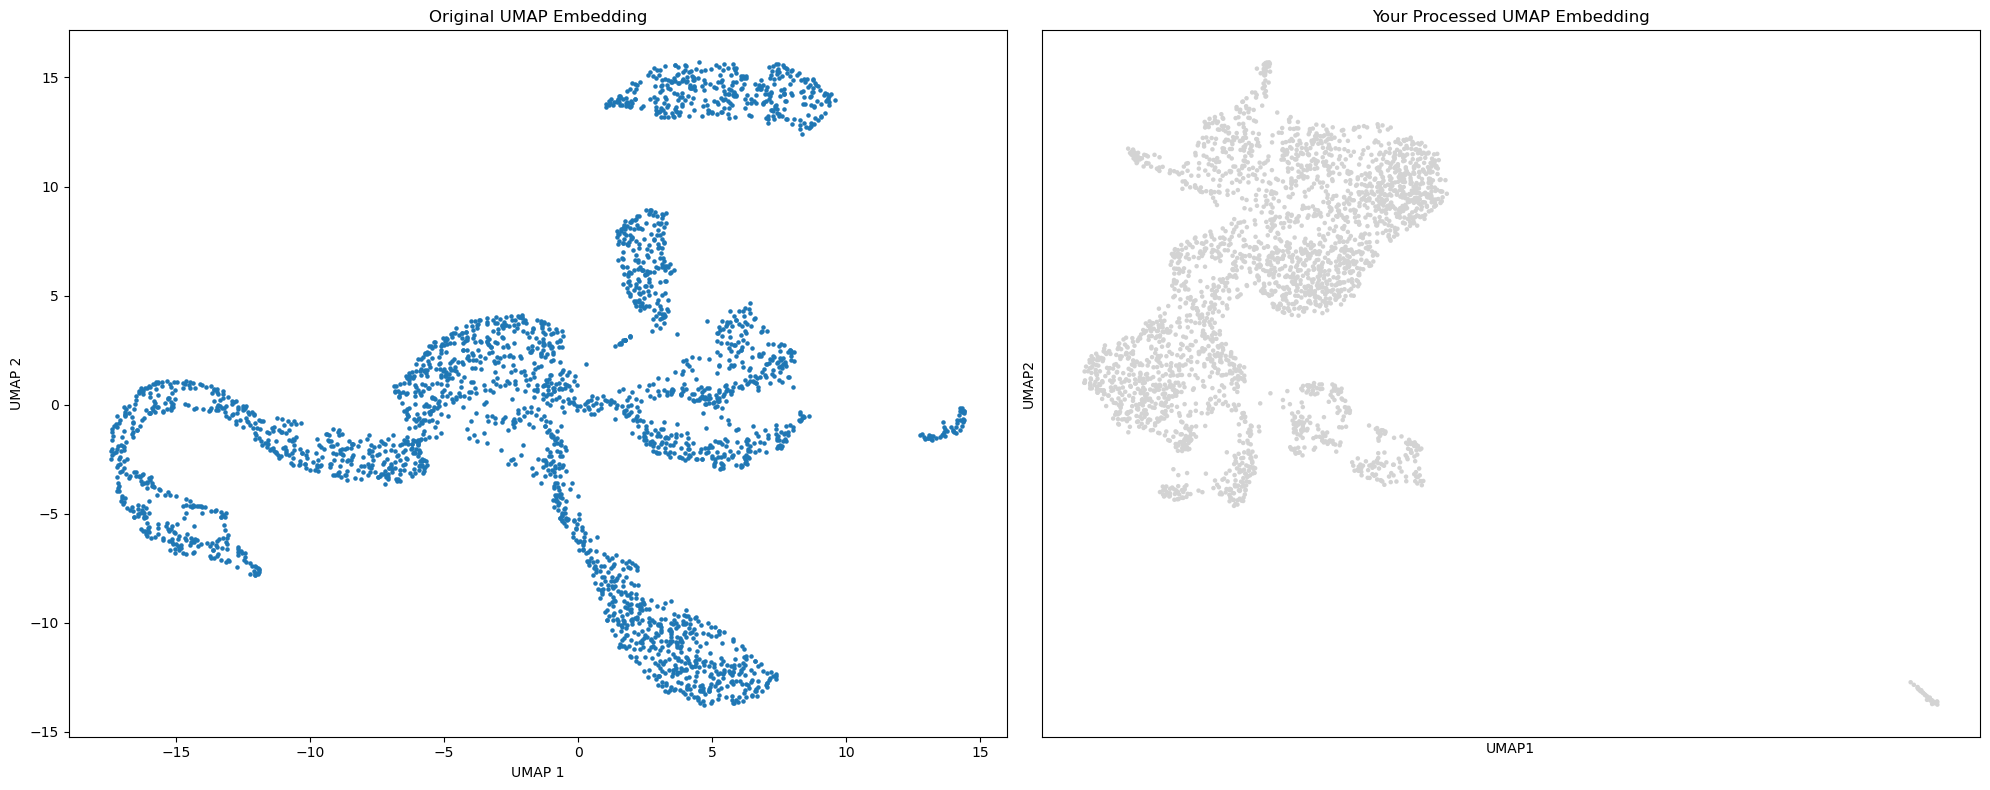

In [5]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: The UMAP from the original data
axes[0].scatter(
    adata_original.obsm['X_umap'][:, 0],
    adata_original.obsm['X_umap'][:, 1],
    s=5
)
axes[0].set_title("Original UMAP Embedding")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

# Plot 2: The UMAP from your processed data
sc.pl.umap(
    adata_processed,
    ax=axes[1],
    show=False,
    title="Your Processed UMAP Embedding"
)

plt.tight_layout()
plt.show()

Here we can see the original UMAP embedding that the original data has, vs the UMAP that i got after processing the data. The differences are clear, the original has a better spaced data with clear segregation while mine looks more muddles in every aspect.

The overall shape might be somewhat similar, indicating similar their origins.

The difference really looks like an example of data before and after batch correction.

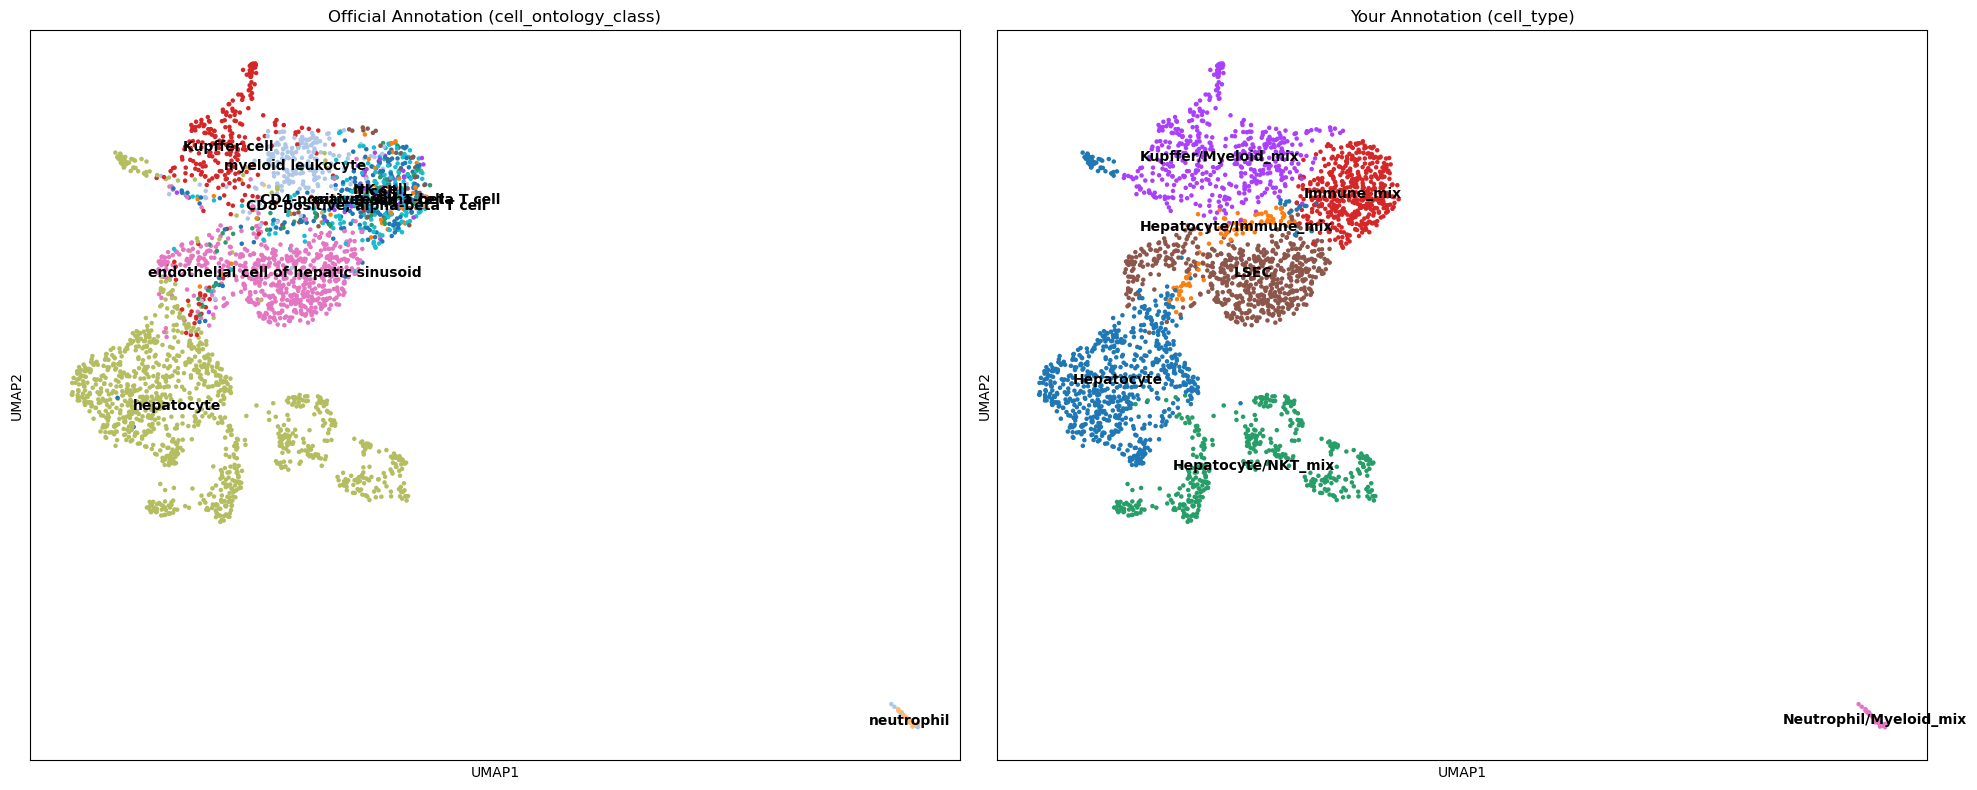

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Add the original annotation as a new column in your processed data.
# This makes the data self-contained for plotting.
adata_processed.obs['official_annotation'] = adata_original.obs['cell_ontology_class'].values

# Ensure it's treated as a category for proper coloring and legend.
adata_processed.obs['official_annotation'] = pd.Categorical(adata_processed.obs['official_annotation'])

# Plot 1: The official 'cell_ontology_class' on your UMAP
# Now, we simply refer to the new column name.
sc.pl.umap(
    adata_processed,
    color='official_annotation', # Use the new column name
    ax=axes[0],
    show=False,
    title="Official Annotation (cell_ontology_class)",
    legend_loc='on data' # Scanpy can now handle the legend correctly
)

# Plot 2: Your 'cell_type' annotation on your UMAP
# This part was already correct.
sc.pl.umap(
    adata_processed,
    color='cell_type',
    ax=axes[1],
    show=False,
    title="Your Annotation (cell_type)",
    legend_loc='on data'
)

plt.tight_layout()
plt.show()

This is a very informative plot comparison between how each specific cell was classified in the original data and how my data was classified.

Overall it looks well annotated with the mixed clusters corresponding to their larger populations inside their clusters, aligning with our conclusions earlier in the comparisons.

Now i want to apply a senescent signature to the original data, usign SenMayo, CellAge and Hernandez Segura, to compare whether after the processing that i did on the data the identification of senescence by these gene sets changes.

In [7]:
# --- STEP 1: LOAD THE ORIGINAL TABULA MURIS DATA ---
# This is the main change: we now load the official annotated file.
print("Loading the original Tabula Muris Senis annotated data...")
original_file = "tabula-muris-senis-facs-processed-official-annotations-Liver.h5ad"
adata = sc.read_h5ad(original_file)
print(f"Successfully loaded {original_file}")


# --- STEP 2: CALCULATE AND ADD THE SENMAYO SCORE ---
# This section remains unchanged.
print("\n--- Calculating SenMayo Score ---")
try:
    senmayo_gene_sets = gp.read_gmt(path="SAUL_SEN_MAYO.v2025.1.Mm.gmt")
    senmayo_genes = list(senmayo_gene_sets["SAUL_SEN_MAYO"])
    print(f"Loaded {len(senmayo_genes)} SenMayo genes.")
    sc.tl.score_genes(adata, senmayo_genes, score_name='SenMayo_score')
    print("SenMayo score added to adata.obs.")
except FileNotFoundError:
    print("SAUL_SEN_MAYO.v2025.1.Mm.gmt not found. Skipping SenMayo score calculation.")


# --- STEP 3: CALCULATE AND ADD THE CELLAGE SCORE ---
# This section remains unchanged.
print("\n--- Calculating CellAge Score ---")
try:
    cellage_df = pd.read_csv("cellage3.tsv", sep="\t")
    human_cellage_genes = cellage_df.loc[cellage_df["Senescence Effect"] == "Induces", "Gene symbol"].tolist()
    print(f"Extracted {len(human_cellage_genes)} human genes from CellAge.")

    print("Finding mouse orthologs for CellAge genes...")
    mg = MyGeneInfo()
    human_query = mg.querymany(human_cellage_genes, scopes="symbol", species="human", fields="homologene", verbose=False)
    mouse_gene_ids = []
    for item in human_query:
        if isinstance(item.get('homologene'), dict) and 'genes' in item['homologene']:
            for g in item["homologene"]["genes"]:
                if g[0] == 10090: # Mouse taxon ID
                    mouse_gene_ids.append(g[1])
    mouse_gene_ids = sorted(list(set(mouse_gene_ids)))
    mouse_gene_info = mg.getgenes(mouse_gene_ids, fields='symbol', verbose=False)
    mouse_cellage_genes = [info['symbol'] for info in mouse_gene_info if 'symbol' in info]
    print(f"Converted to {len(mouse_cellage_genes)} mouse ortholog symbols.")

    sc.tl.score_genes(adata, mouse_cellage_genes, score_name='CellAge_up_score')
    print("CellAge score added to adata.obs.")
except FileNotFoundError:
    print("cellage3.tsv not found. Skipping CellAge score calculation.")


# --- STEP 4: CALCULATE AND ADD HERNANDEZ SEGURA SCORES ---
# This section remains unchanged.
print("\n--- Calculating Hernandez Segura Scores ---")
hernandez_segura_enriched_human = [
    'ACADVL', 'ADPGK', 'B4GALT7', 'BCL2L2', 'CCND1', 'CHMP5', 'DDA1', 'DGKA', 'DYNLT3', 'FAM214B', 'GBE1',
    'GDNF', 'KLC1', 'MT-CYB', 'NOL3', 'P4HA2', 'PDLIM4', 'PLK3', 'PLXNA3', 'POFUT2', 'RAI14', 'SCOC',
    'SLC10A3', 'SLC16A3', 'SUSD6', 'TAF13', 'TMEM87B', 'TOLLIP', 'TSPAN13', 'UFM1', 'ZBTB7A', 'ZNHIT1'
]
hernandez_segura_depleted_human = [
    'ARHGAP35', 'ARID2', 'ASCC1', 'C2CD5', 'CNTLN', 'CREBBP', 'EFNB3', 'GSTM4', 'ICE1', 'KCTD3', 'MEIS1',
    'NFIA', 'PATZ1', 'PCIF1', 'PDS5B', 'RHNO1', 'SMO', 'SPATA6', 'SPIN4', 'STAG1', 'TRDMT1', 'USP6NL', 'ZC3H4'
]

if 'mg' not in locals():
    mg = MyGeneInfo()

def convert_human_to_mouse(gene_list):
    human_query = mg.querymany(gene_list, scopes="symbol", species="human", fields="homologene", verbose=False)
    mouse_ids = []
    for item in human_query:
        if isinstance(item.get('homologene'), dict) and 'genes' in item['homologene']:
            for g in item["homologene"]["genes"]:
                if g[0] == 10090:
                    mouse_ids.append(g[1])
    mouse_ids = sorted(list(set(mouse_ids)))
    mouse_info = mg.getgenes(mouse_ids, fields='symbol', verbose=False)
    mouse_symbols = [info['symbol'] for info in mouse_info if 'symbol' in info]
    return mouse_symbols

print("Finding mouse orthologs for Hernandez Segura genes...")
mouse_hernandez_enriched = convert_human_to_mouse(hernandez_segura_enriched_human)
mouse_hernandez_depleted = convert_human_to_mouse(hernandez_segura_depleted_human)
print(f"Converted to {len(mouse_hernandez_enriched)} enriched and {len(mouse_hernandez_depleted)} depleted mouse orthologs.")

sc.tl.score_genes(adata, mouse_hernandez_enriched, score_name='HernandezSegura_enriched_score')
print("HernandezSegura_enriched_score added to adata.obs.")
sc.tl.score_genes(adata, mouse_hernandez_depleted, score_name='HernandezSegura_depleted_score')
print("HernandezSegura_depleted_score added to adata.obs.")


# --- STEP 5: VERIFY AND SAVE THE FINAL OBJECT ---
print("\n--- Verification and Saving ---")
# Verify that ALL score columns are now in adata.obs
print("New columns in adata.obs include:", [col for col in adata.obs.columns if '_score' in col])

# This is the second main change: we save to a new, clearly named output file.
output_filename = "tabula-muris-senis-facs-Liver_with_senescence_scores.h5ad"
adata.write_h5ad(output_filename)
print(f"\nSuccessfully saved original data with new scores to '{output_filename}'")

Loading the original Tabula Muris Senis annotated data...
Successfully loaded tabula-muris-senis-facs-processed-official-annotations-Liver.h5ad

--- Calculating SenMayo Score ---
Loaded 117 SenMayo genes.


c:\Users\lukas\miniconda3\envs\sc_env\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(
c:\Users\lukas\miniconda3\envs\sc_env\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(


SenMayo score added to adata.obs.

--- Calculating CellAge Score ---
Extracted 417 human genes from CellAge.
Finding mouse orthologs for CellAge genes...


Converted to 366 mouse ortholog symbols.
       'Ifi207', 'Ifi209', 'Tigar', 'Ccn6', 'Ifi211', 'Atraid', 'Ifi214',
       'Ifi213', 'Ifi208', 'Bnip3l-ps', 'Ifi203-ps', 'Ifi206'],
      dtype='object')


CellAge score added to adata.obs.

--- Calculating Hernandez Segura Scores ---
Finding mouse orthologs for Hernandez Segura genes...


Converted to 31 enriched and 21 depleted mouse orthologs.
HernandezSegura_enriched_score added to adata.obs.
HernandezSegura_depleted_score added to adata.obs.

--- Verification and Saving ---
New columns in adata.obs include: ['SenMayo_score', 'CellAge_up_score', 'HernandezSegura_enriched_score', 'HernandezSegura_depleted_score']

Successfully saved original data with new scores to 'tabula-muris-senis-facs-Liver_with_senescence_scores.h5ad'


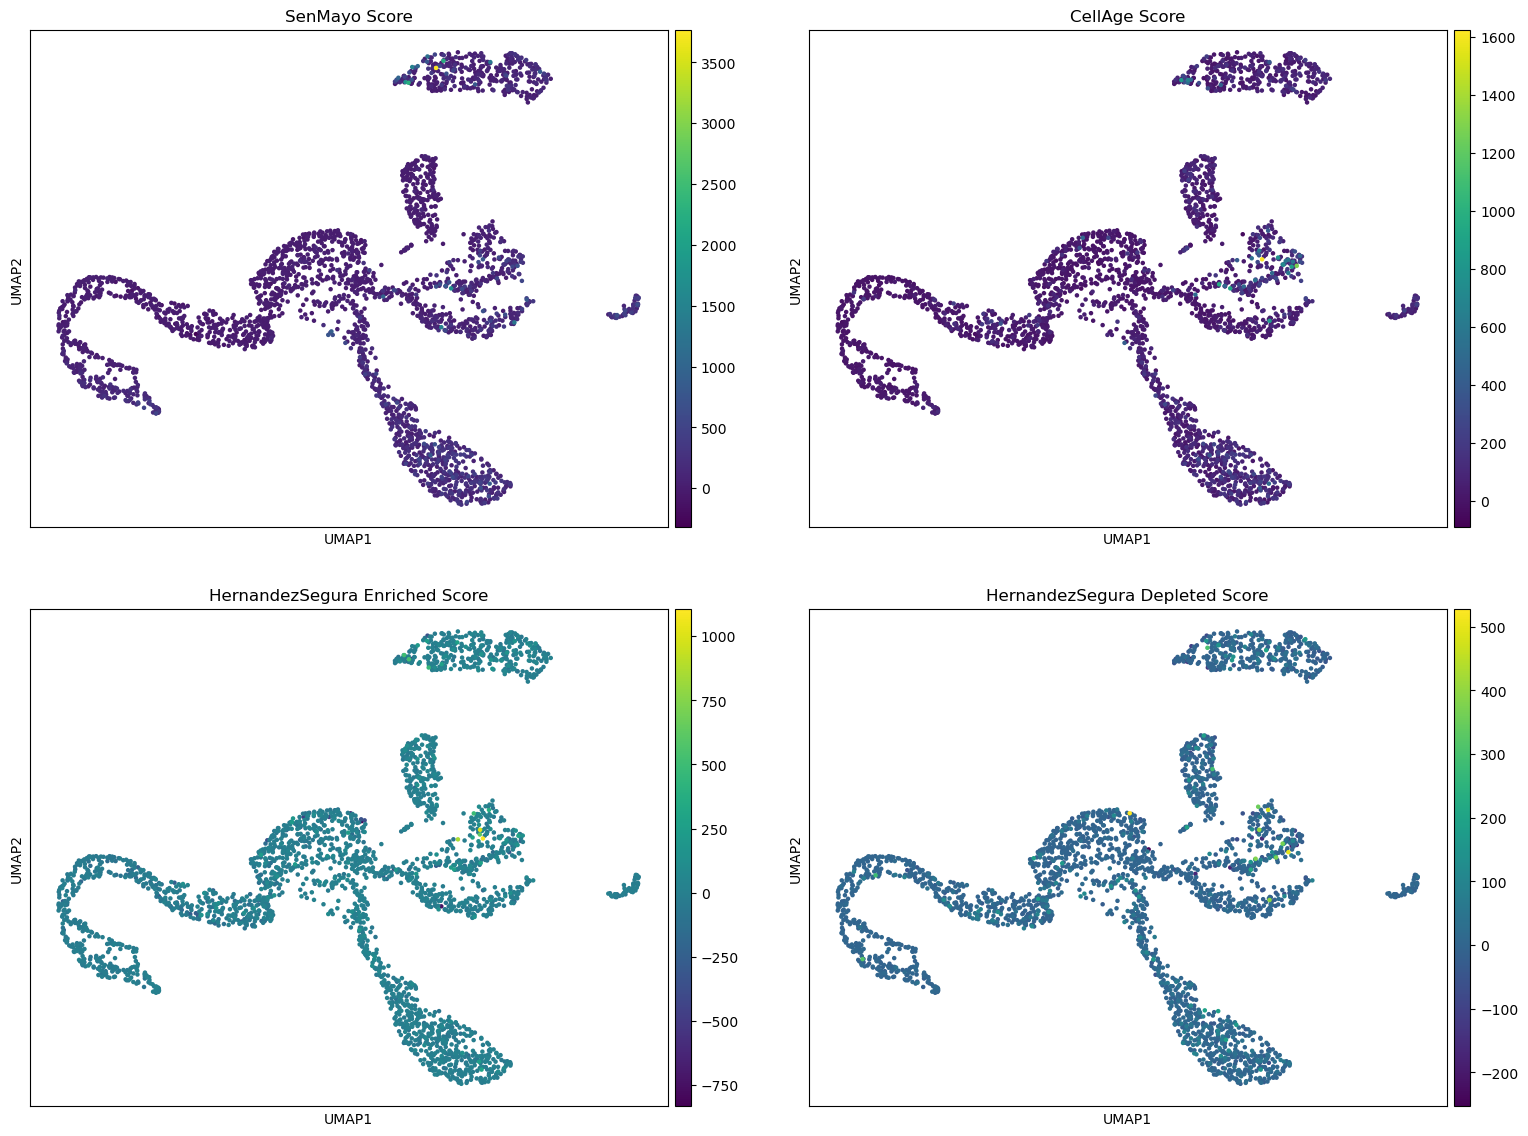

In [8]:
# It's assumed 'adata' is already loaded.
adata = sc.read_h5ad("tabula-muris-senis-facs-Liver_with_senescence_scores.h5ad")

# 1. Create a figure with a 2x2 grid of subplots (two rows, two columns).
# We also adjust the figsize to be more square.
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1 (Top-Left): SenMayo score
sc.pl.umap(
    adata,
    color='SenMayo_score',
    ax=axes[0, 0], # Target the subplot at row 0, column 0
    show=False,
    cmap='viridis',
    title='SenMayo Score'
)

# Plot 2 (Top-Right): CellAge score
sc.pl.umap(
    adata,
    color='CellAge_up_score',
    ax=axes[0, 1], # Target the subplot at row 0, column 1
    show=False,
    cmap='viridis',
    title='CellAge Score'
)

# Plot 3 (Bottom-Left): HernandezSegura enriched score
sc.pl.umap(
    adata,
    color='HernandezSegura_enriched_score',
    ax=axes[1, 0], # Target the subplot at row 1, column 0
    show=False,
    cmap='viridis',
    title='HernandezSegura Enriched Score'
)

# Plot 4 (Bottom-Right): HernandezSegura depleted score
sc.pl.umap(
    adata,
    color='HernandezSegura_depleted_score',
    ax=axes[1, 1], # Target the subplot at row 1, column 1
    show=False,
    cmap='viridis',
    title='HernandezSegura Depleted Score'
)

# 3. Adjust spacing and display the final composite figure
plt.tight_layout(pad=3.0) # Add some padding to prevent titles from overlapping
plt.show()

In [11]:
# 1. Get descriptive statistics for each score
print("\nStatistics for SenMayo_score:")
print(adata.obs['SenMayo_score'].describe())

print("\nStatistics for CellAge_up_score:")
print(adata.obs['CellAge_up_score'].describe())

print("\nStatistics for HernandezSegura_combined_score:")
print(adata.obs['HernandezSegura_combined_score'].describe())


Statistics for SenMayo_score:
count    2859.000000
mean       80.486467
std       171.439932
min      -321.222075
25%         1.777758
50%        29.190274
75%       106.937947
max      3768.949363
Name: SenMayo_score, dtype: float64

Statistics for CellAge_up_score:
count    2859.000000
mean       50.603828
std        88.542069
min       -91.460708
25%         5.470249
50%        23.888426
75%        67.173392
max      1626.427324
Name: CellAge_up_score, dtype: float64

Statistics for HernandezSegura_combined_score:
count    2859.000000
mean      -22.250114
std        88.883461
min     -1106.424961
25%       -43.041096
50%       -12.949393
75%         2.050700
max      1266.832444
Name: HernandezSegura_combined_score, dtype: float64



--- Defining consistent thresholds for all analyses ---
Thresholds set: SenMayo > 107, CellAge > 67, Hernandez > 2

Total number of cells above each threshold:
is_high_SenMayo      714
is_high_CellAge      716
is_high_Hernandez    718
dtype: int64
---------------------------------------------------------

--- Running Part 4: Analysis of All Three Signatures ---

Cell Counts (3 Signatures):
senescence_category_3
Low in All              1468
High in 1 Signature      773
High in 2 Signatures     479
High in All 3            139
Name: count, dtype: int64
---------------------------------------------------------
Generating the second plot...


<Figure size 800x700 with 0 Axes>

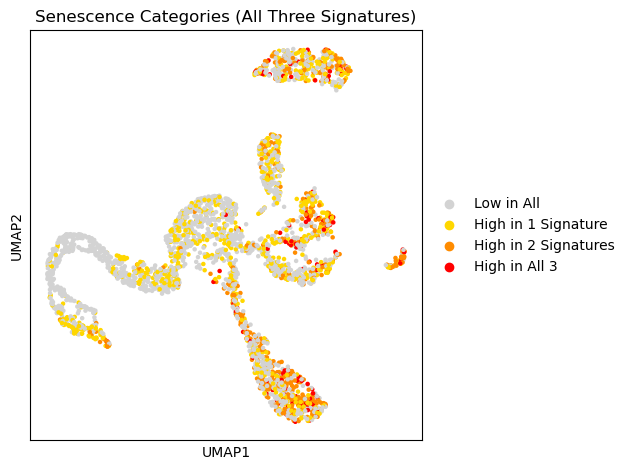

In [13]:
# ---------------------------------------------------------------------------
# --- PART 2: DEFINE PARAMETERS AND CREATE BOOLEAN FLAGS ---
# All thresholds are defined ONCE here for consistency.
# ---------------------------------------------------------------------------
print("\n--- Defining consistent thresholds for all analyses ---")
senmayo_threshold = 107
cellage_threshold = 67
hernandez_threshold = 2

# Create the combined Hernandez score first
adata.obs['HernandezSegura_combined_score'] = adata.obs['HernandezSegura_enriched_score'] - adata.obs['HernandezSegura_depleted_score']

# Create and store a single set of boolean flags to be used everywhere
adata.obs['is_high_SenMayo'] = adata.obs['SenMayo_score'] > senmayo_threshold
adata.obs['is_high_CellAge'] = adata.obs['CellAge_up_score'] > cellage_threshold
adata.obs['is_high_Hernandez'] = adata.obs['HernandezSegura_combined_score'] > hernandez_threshold

print(f"Thresholds set: SenMayo > {senmayo_threshold}, CellAge > {cellage_threshold}, Hernandez > {hernandez_threshold}")
print("\nTotal number of cells above each threshold:")
print(adata.obs[['is_high_SenMayo', 'is_high_CellAge', 'is_high_Hernandez']].sum())
print("---------------------------------------------------------")

# ---------------------------------------------------------------------------
# --- PART 4: ANALYSIS of All Three Signatures ---
# ---------------------------------------------------------------------------
print("\n--- Running Part 4: Analysis of All Three Signatures ---")

sum_of_conditions = adata.obs['is_high_SenMayo'].astype(int) + \
                    adata.obs['is_high_CellAge'].astype(int) + \
                    adata.obs['is_high_Hernandez'].astype(int)

# Create the 3-signature categorical column
adata.obs['senescence_category_3'] = 'Low in All'
adata.obs.loc[sum_of_conditions == 1, 'senescence_category_3'] = 'High in 1 Signature'
adata.obs.loc[sum_of_conditions == 2, 'senescence_category_3'] = 'High in 2 Signatures'
adata.obs.loc[sum_of_conditions == 3, 'senescence_category_3'] = 'High in All 3'

adata.obs['senescence_category_3'] = pd.Categorical(
    adata.obs['senescence_category_3'],
    categories=['Low in All', 'High in 1 Signature', 'High in 2 Signatures', 'High in All 3'], ordered=True)

print("\nCell Counts (3 Signatures):")
print(adata.obs['senescence_category_3'].value_counts())
print("---------------------------------------------------------")

# Visualize the 3-score categories on the original UMAP plot
print("Generating the second plot...")
plt.figure(figsize=(8, 7))
sc.pl.umap(adata, color='senescence_category_3', title='Senescence Categories (All Three Signatures)',
           palette={'Low in All': 'lightgrey', 'High in 1 Signature': 'gold', 'High in 2 Signatures': 'darkorange', 'High in All 3': 'red'}, show=False)
plt.tight_layout()
plt.show()

As we can see the cells characterized as senescent are in different locations but they are the exact same cells as i identified as senescent (in all three different signatures), providing a clear and validated conclusion that any transformation that i executed in my data did not alter the overall biological signals, from the cell type to the senescence identification.